---
title: Strained Gold Widget
authors: [gvarnavides]
date: 2025-02-01
---

In [1]:
%matplotlib widget
import numpy as np
import ase
import abtem
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.spatial.transform import Rotation

import ipywidgets
import py4DSTEM

abtem.config.set({"dask.lazy":False});

In [3]:
def inside_cell(positions,cell_dim):
    lx,ly,lz = cell_dim/2
    x,y,z = positions.T
    
    return np.logical_and.reduce(
        (
            x > -lx,
            x < lx,
            y > -ly,
            y < ly,
            z > -lz,
            z < lz,
        )
    )    

In [4]:
# gold = ase.build.bulk("Au",cubic=True,a=4)
cell_dim = np.array([150,40,40])

gold_unit_cell = ase.Atoms(
    symbols="Au4",
    scaled_positions=[
        [0.25,0.25,0.25],
        [0.75,0.75,0.25],
        [0.75,0.25,0.75],
        [0.25,0.75,0.75]
    ],
    cell=[4,4,4],
    pbc=True
)

strained_gold = gold_unit_cell * (40,10,10)
strained_gold.positions[:,0] *= 1+(strained_gold.positions[:,0]/cell_dim[0]/2)
strained_gold.translate(-strained_gold.cell.lengths()/2)
strained_gold = strained_gold[inside_cell(
    strained_gold.positions,
    cell_dim
)]
strained_gold.translate(cell_dim/2)
strained_gold.cell = cell_dim

In [5]:
grain = strained_gold.copy()
grain_visualize = strained_gold.copy()

In [6]:
potential = abtem.Potential(
    grain,
    sampling=0.2,
    slice_thickness=cell_dim[2],
).build(
)

In [7]:
energy = 300e3
semiangle_cutoff = 3

probe = abtem.Probe(
    semiangle_cutoff=semiangle_cutoff,
    energy=energy,
).match_grid(
    potential
)

In [8]:
detector = abtem.PixelatedDetector(max_angle=None)

In [9]:
array_to_mutate = [
    np.array([25,20])
]

In [10]:
pos = np.array(array_to_mutate)
custom_scan = abtem.CustomScan(pos)

In [11]:
dp = probe.scan(
    potential,
    custom_scan,
    detector
).crop(
    max_angle=probe.cutoff_angles[0]
).block_direct(
)

In [12]:
dpi = 72
with plt.ioff():
    fig = plt.figure(figsize=(675/dpi,200/dpi),dpi=dpi)
    
gs = GridSpec(1, 2, figure=fig,width_ratios=[4,1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

abtem.show_atoms(grain_visualize,plane='xy',tight_limits=True,ax=ax1)
scatter = ax1.scatter(
    pos[0,0],
    pos[0,1],
    color='r'
)

dp.show(
    cmap='magma',
    ax=ax2
)
dp_im = ax2.images[0]
gs.tight_layout(fig)

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '680px'
fig.canvas.layout.height = "235px"
fig.canvas.toolbar_position = 'bottom'

def update_plots():
    """ """
    pos = np.array(array_to_mutate)
    custom_scan = abtem.CustomScan(pos)
    
    dp = probe.scan(
        potential,
        custom_scan,
        detector
    ).crop(
        max_angle=probe.cutoff_angles[0]
    ).block_direct(
    )

    dp_im.set_data(dp.array)
    scatter.set_offsets(pos)
    fig.canvas.draw_idle()
    return None

def onmove(event):
    """ """
    pos = np.array([event.xdata,event.ydata])
    if pos[0] is not None:
        array_to_mutate[0] = pos
        update_plots()
    return None

cid = fig.canvas.mpl_connect('motion_notify_event',onmove)
None

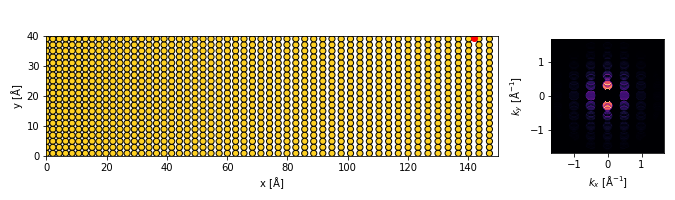

In [14]:
#| label: app:strained_gold
fig.canvas